In [2]:
import numpy as np

import seaborn as sns

sns.set_style("darkgrid")
import scipy
import scipy.signal
import scipy.interpolate
import matplotlib.pyplot as plt


Denote a molecule with $n \in \mathbb{N}$ atoms by the tuple $(X, Z)$ where

- $X \in \mathbb{R}^{n \times 3}$ is an $n \times 3$ matrix containing the coordinates for each atom and
- $Z \in A \subseteq \mathbb{N}^n$ is a vector of $n$ atomic numbers where $Z_i$ is the atomic number corresponding to the atom with coordinates $X_i$.


Then we define the repulsive energy of a molecule $M = (X, Z)$ as a sum over $n(n-1)/2$ distinct pair potentials

$$E_\text{rep} = \sum_{i < j} f_{Z_i,Z_j}(\|X_i - X_j\|)$$

The pair potential functions $f_{Z_i,Z_j} : \mathbb{R} \to \mathbb{R}$ defined for all $Z_i, Z_j \in A$ have a functional form given by the linear basis expansion $\sum_{i=1}^T \beta_{Z_i,Z_j}^i \phi^i(\|X_i - X_j\|)$. The function $\phi^i$ is a third degree B-spline basis function with $T$ knots $t_1, \ldots, t_T$.
<!-- 
 recursively defined by the following recurrence relation evaluated at $k=3$:

\begin{align*}
B^i_{0}(x) &= \begin{cases}1 &\text{ if } x \in [t_i, t_{i+1})\\0 &\text{ otherwise} \end{cases}\\
B^i_{k}(x) &= \frac{x - t_i}{t_{i+k} - t_i} B^i_{k-1}(x) + \frac{t_{i+k+1} - x}{t_{i+k+1} - t_{i+1}} B^{i+1}_{k-1}(x)
\end{align*} -->

In [3]:
(lambda n: n*(n-1)/2)(4)

6.0

In [195]:
coefs2 = coefs.copy()

In [242]:
coefs2 = coefs.copy()
coefs = coefs2.copy()

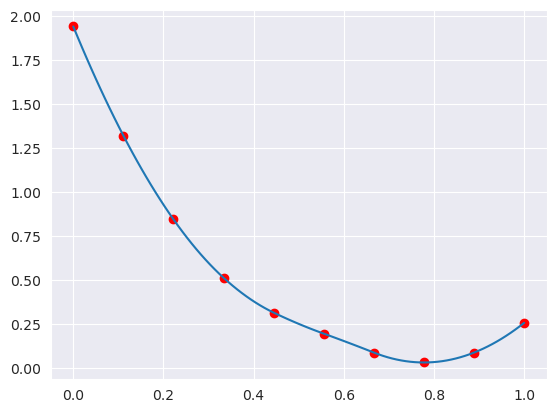

In [452]:
def random_spline(knots):
    coef_min = 0
    coef_max = 1
    coef_noise_stdev = 1 / 10
    polynomial_degree = np.random.uniform(2, 7)
    coefs = np.minimum.accumulate(
        np.linspace(coef_max, coef_min, len(knots)) ** polynomial_degree
        + np.random.rand(len(knots)) * coef_noise_stdev
    )
    spline_degree = 2
    s = scipy.interpolate.BSpline(knots, coefs, spline_degree, extrapolate=True)
    return s


n_knots = 10
knots = np.linspace(0, 1, n_knots)
x = np.linspace(knots.min(), knots.max(), 100)
s = random_spline(knots)
plt.plot(x, s(x))
plt.scatter(knots, s(knots), color="red")

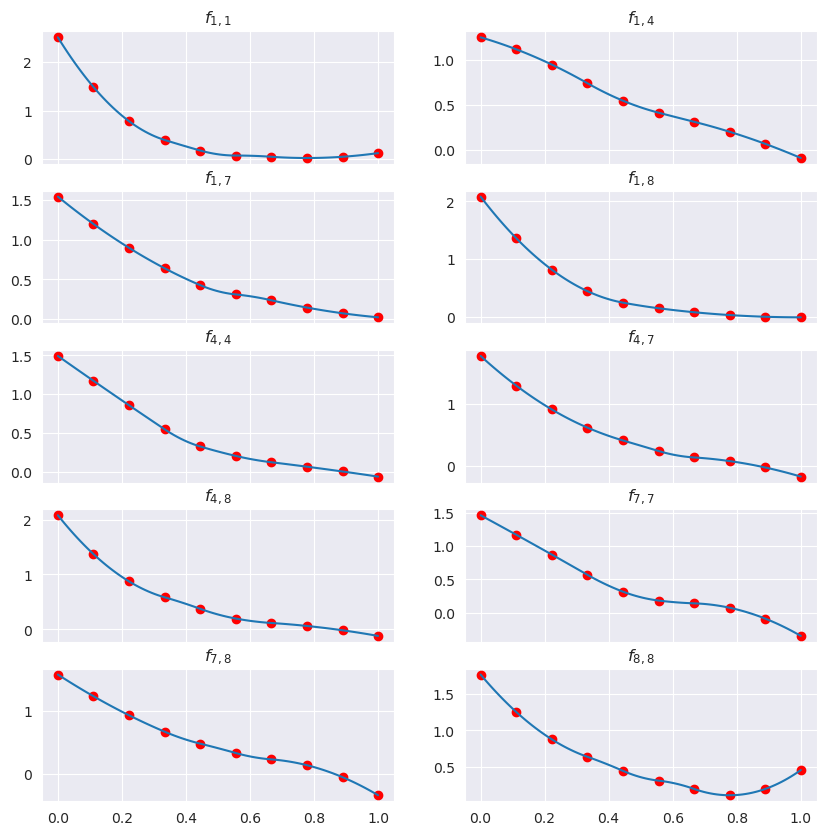

In [490]:
import itertools

atomic_numbers = [1, 4, 7, 8]
pair_potentials = {}

fig, ax = plt.subplots(len(atomic_numbers)*(len(atomic_numbers)+1)//2 // 2, 2, figsize=(10, 10), sharex=True)
for i, (z_i, z_j) in enumerate(itertools.combinations_with_replacement(atomic_numbers, 2)):
    x = np.linspace(knots.min(), knots.max(), 100)
    s = random_spline(knots)
    pair_potentials[(z_i, z_j)] = s
    ax[(i//2), i%2].plot(x, s(x))
    ax[(i//2), i%2].scatter(knots, s(knots), color="red")
    ax[(i//2), i%2].set_title(f"$f_{{{z_i},{z_j}}}$")

In [510]:
def random_molecule_coordinates(n_atoms):
    return np.random.rand(n_atoms, 3)

def random_molecule_formula(atomic_numbers, n_atoms):
    return np.sort(np.random.choice(atomic_numbers, n_atoms))

random_molecule_coordinates(3)
random_molecule_formula(atomic_numbers, 5)

array([1, 4, 4, 4, 8])

In [511]:
n_conformations_per_formula = 100
n_formulas_per_size = 100
sizes = range(3, 9)

molecules = []

for n_atoms in sizes:
    for _ in range(n_formulas_per_size):
        formula = random_molecule_formula(atomic_numbers, n_atoms)
        for _ in range(n_conformations_per_formula):
            coordinates = random_molecule_coordinates(n_atoms)
            molecules.append((formula, coordinates))

In [35]:
def bspline_basis(x, k, knots, compute_derivatives=False, **kwargs):
    """Cox - de Boor function for B-splines"""

    if not k:
        return np.where(np.all([knots[:-1] <= x, x < knots[1:]], axis=0), 1.0, 0.0)

    b_k_minus_1 = bspline_basis(x, k - 1, knots, _recursing=True)

    numerator_1 = x - knots[:-k]
    denominator_1 = knots[k:] - knots[:-k]

    numerator_2 = knots[(k + 1) :] - x
    denominator_2 = knots[(k + 1) :] - knots[1:-k]

    # Adjust numerators if computing derivatives
    if compute_derivatives and not kwargs.get("_recursing"):
        numerator_1 = k
        numerator_2 = -k

    with np.errstate(divide="ignore", invalid="ignore"):
        term_1 = np.where(denominator_1 != 0, (numerator_1 / denominator_1), 0.0)
        term_2 = np.where(denominator_2 != 0, (numerator_2 / denominator_2), 0.0)

    return term_1[:-1] * b_k_minus_1[:-1] + term_2 * b_k_minus_1[1:]


def plot(p, knots, num=1000):
    x_min = np.min(knots)
    x_max = np.max(knots)

    x = np.linspace(x_min, x_max, num=num)
    N = np.array([bspline_basis(i, p, knots) for i in x]).T

    for n in N:
        plt.plot(x, n)

    return plt.show()


In [36]:
bspline_basis(0.5, 3, knots, compute_derivatives=False)

array([0.        , 0.02083333, 0.47916667, 0.47916667, 0.02083333,
       0.        ])

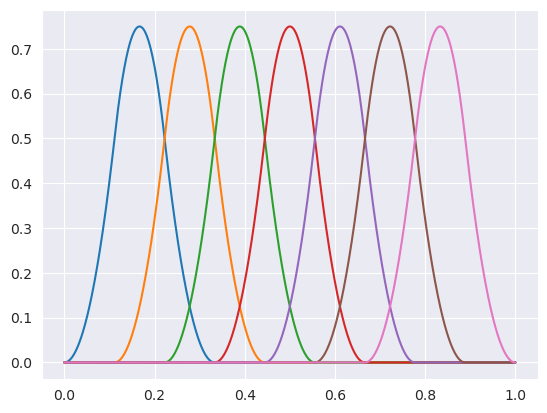

In [37]:
plot(2, knots)